# Exploratory Analysis of Water Quality Data II - Continuous Data

# Sampling Location

This document includes Python code and results of the exploratory analysis of water quality data in the SEACAR Pilot project.

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy      as np
import pandas     as pd
import geopandas  as gpd
import contextily as cx
import seaborn    as sns
import warnings

import misc.misc
warnings.filterwarnings('ignore')

## 1. Data loading and preprocessing
Read the csv file and shapefile of managed areas.

In [ ]:
# load shapefile of managed areas
areaShp = gpd.read_file("../GIS_data/ORCP_Managed_Areas_Oct2021.shp")

# Load and preprocess the WQ data
df2, listPara, listArea, listValue, dictUnits, dictMonth, dictArea = misc.misc.load_data('../OEAT_Continuous-2022-Nov-04.csv')

## 2. Sampling locations

This step is to calculate histogram of samples at unique locations.


### 2.1 Sample frequencies at unique locations
First, aggregate the data by location and parameter name.

In [19]:
plt.rcParams['figure.figsize'] = [16, 8]

dfLoc  = df2.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName","ProgramLocationID"])["ResultValue"].agg("count").reset_index()

dfLoc = dfLoc.rename(columns={"ResultValue": "samples"})

dfLoc.loc[dfLoc["samples"] == 1,['sample_type']] ='Random Point'
dfLoc.loc[dfLoc["samples"] > 1,['sample_type']] ='Fixed Point'

# print unique locations and frequencies
display(df2.groupby(['Latitude_DD', 'Longitude_DD']).size().reset_index(name='Freq'))

Latitude_DD  Longitude_DD     Freq
0     25.758020    -80.167690    43873
1     25.769800    -80.180850    46598
2     25.777300    -80.204000   119574
3     25.821730    -80.151250   329591
4     25.830030    -80.158600   212858
5     25.846841    -80.182861   260047
6     26.355000    -81.844500  1361971
7     26.385900    -81.846300  1266827
8     26.434900    -81.911400  1533954
9     26.449685    -81.871465    91531
10    26.464278    -82.104556      402
11    26.562700    -82.070400  1437301
12    26.628800    -82.067400  1147707
13    26.667800    -82.094600  1342481
14    26.743833    -82.060028      193
15    26.755333    -82.059472      185
16    29.101817    -83.076467   458511
17    29.281351    -83.111237      123
18    29.287817    -83.166083   587491
19    29.647203    -83.421196   108622
20    29.667071    -81.257403  1591635
21    29.737041    -81.245953  1785508
22    29.813933    -83.628917   649795
23    29.868851    -81.307428  1680626
24    29.994720    -81.329560    34918
25    30.050857    -81.367465  1270616

Plot histograms of samples at unique positions.

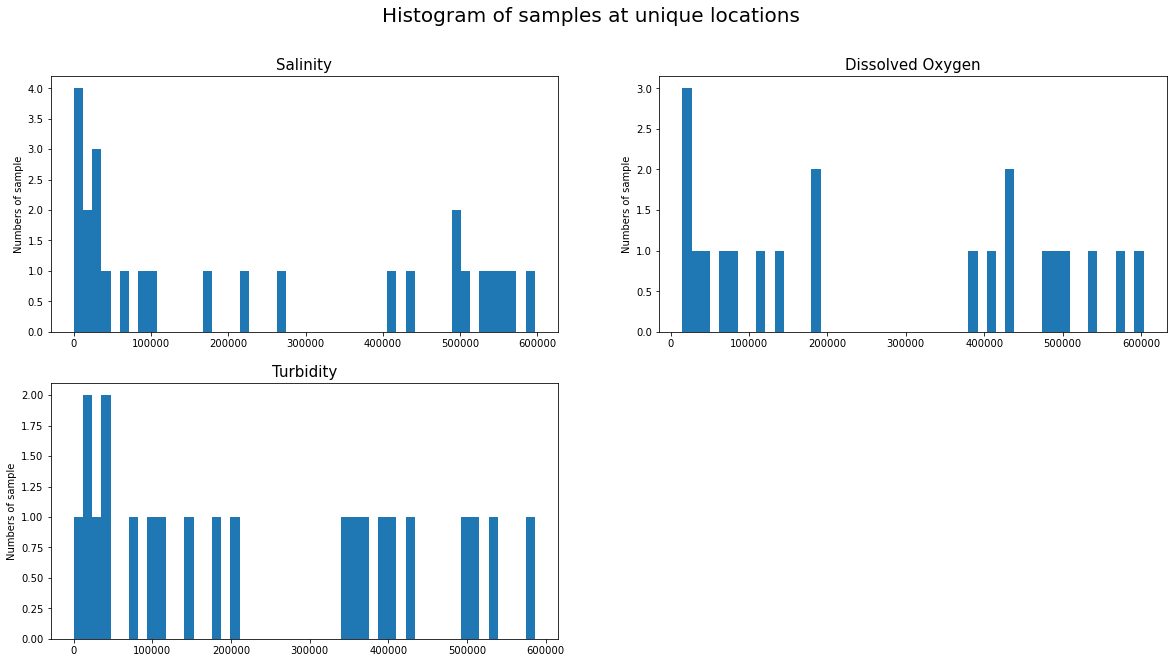

In [20]:
plt.rcParams['figure.figsize'] = [20, 16]

i = 0

fig = plt.figure()
plt.suptitle("Histogram of samples at unique locations", fontsize = 20, y = 0.94)

for para in listPara:
    dfNew = dfLoc[dfLoc['ParameterName']==para]
    if dfNew["ParameterName"].count() != 0:
        ax = fig.add_subplot(3,2,i+1)
        ax.set_title(para, size=15) # Title  
        ax.hist(dfNew["samples"],bins=50)
        i=i+1
        plt.ylabel("Numbers of sample")

## 3 Spatial distribution of sampling locations

Convert sampling points of salinity to GeoDataFrame

In [21]:
# Group data by location, parametername and managed area name
gdfLoc = gpd.GeoDataFrame(dfLoc, geometry = gpd.points_from_xy(dfLoc.Longitude_DD, dfLoc.Latitude_DD), crs="EPSG:4326").to_crs("EPSG:32617")

Plot sampling locations in all years.

Station maps are shown as followed.

In [22]:
dfID  = pd.DataFrame(df2.groupby(["ProgramLocationID","Longitude_DD","Latitude_DD","ManagedAreaName"]).sum().reset_index())
dfID  = dfID[["ProgramLocationID","Longitude_DD","Latitude_DD","ManagedAreaName"]]
gdfID = gpd.GeoDataFrame(dfID, geometry = gpd.points_from_xy(dfID.Longitude_DD, dfID.Latitude_DD), crs="EPSG:4326").to_crs("EPSG:32617")

In [23]:
Paired = matplotlib.cm.get_cmap('Paired', 12)
print(Paired)

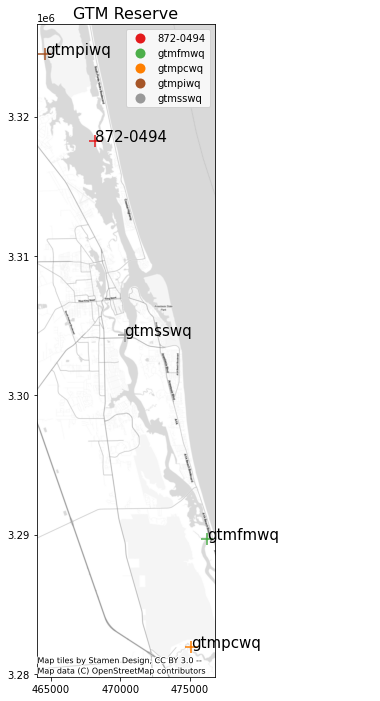

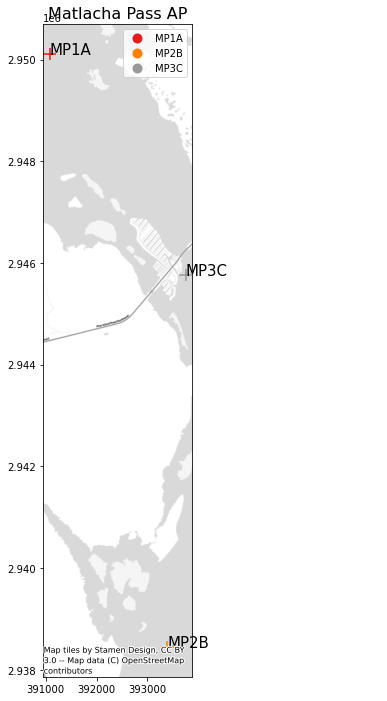

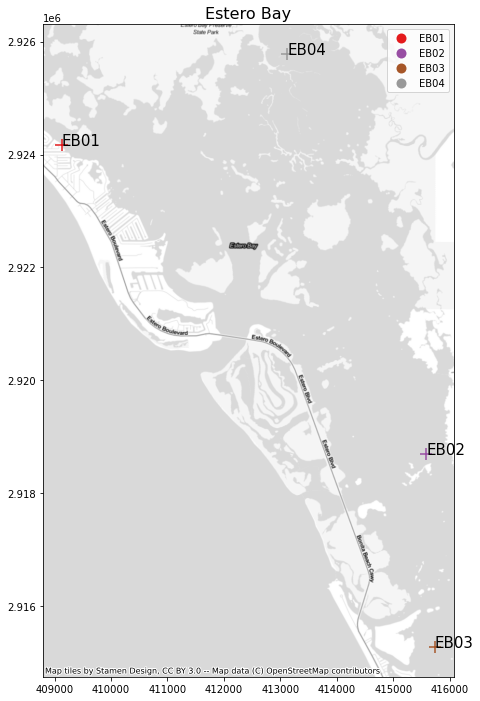

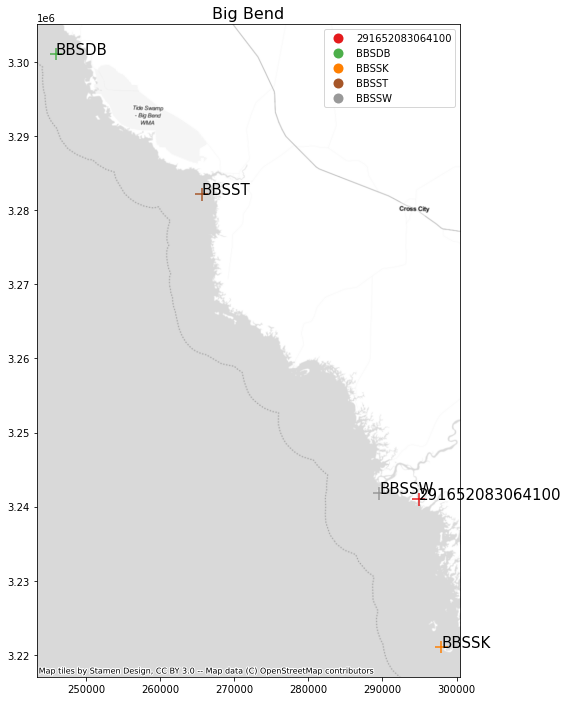

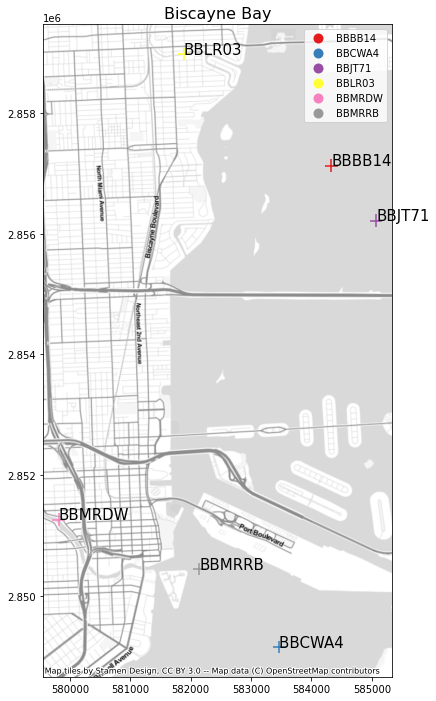

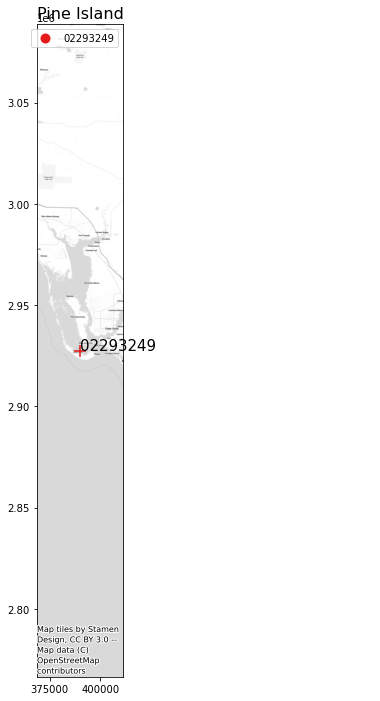

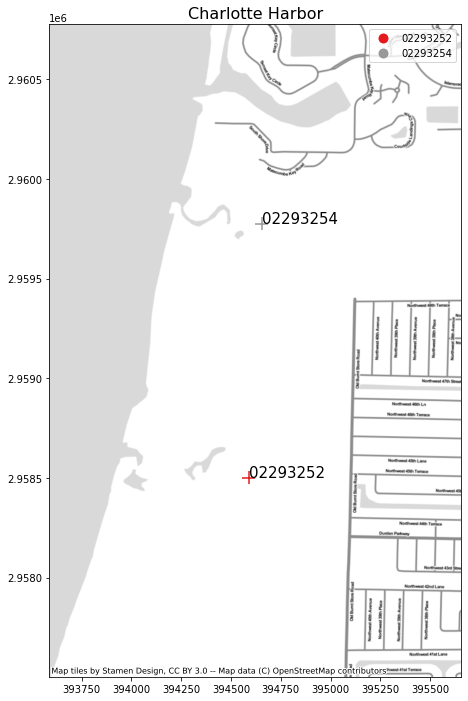

In [24]:
plt.rcParams['figure.figsize'] = [12, 12]

for area in listArea:
    gdfMap = gdfID[gdfID["ManagedAreaName"] == area]
    X = list(gdfMap.geometry.x)
    Y = list(gdfMap.geometry.y)
    Name = list(gdfMap.ProgramLocationID)
    ax = gdfMap.plot(column ='ProgramLocationID',cmap = 'Set1',marker = "+", markersize=160,legend = True)
    ax.set_title("{}".format(str(dictArea[area])),size=16)
    for i in range(len(Name)):
        plt.annotate(text=Name[i],xy=(X[i],Y[i]),annotation_clip=False,fontsize=15)
    
    # Solve the error of Charlotte Harbor
    if area == "Gasparilla Sound-Charlotte Harbor Aquatic Preserve":
        x1, y1, x2, y2 = gdfMap.total_bounds
        #extent = (x1-0.005,x2+0.005,y1-0.001,y2+0.001)
        extent = (x1-1000,x2+1000,y1-1000,y2+1000)
        ax.axis(extent)
        
    cx.add_basemap(ax,source=cx.providers.Stamen.TonerLite,crs=gdfMap.crs)
    i = 0
    plt.savefig(fig_path+str(dictArea[area]))

### 3.1 Sampling locations of dissolved oxygen in all years

<Figure size 1440x1080 with 0 Axes>

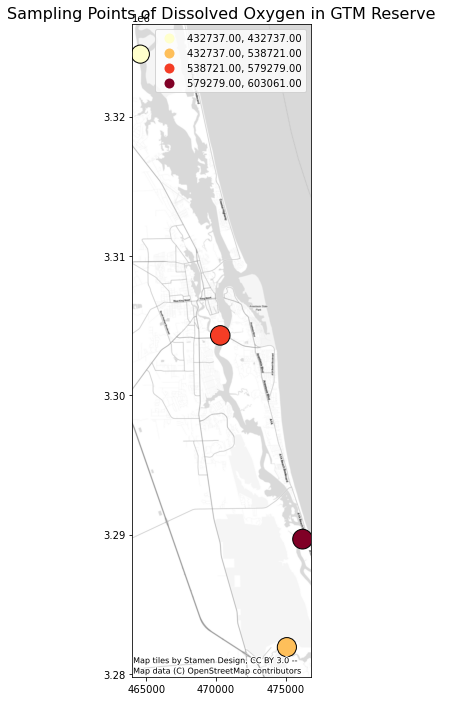

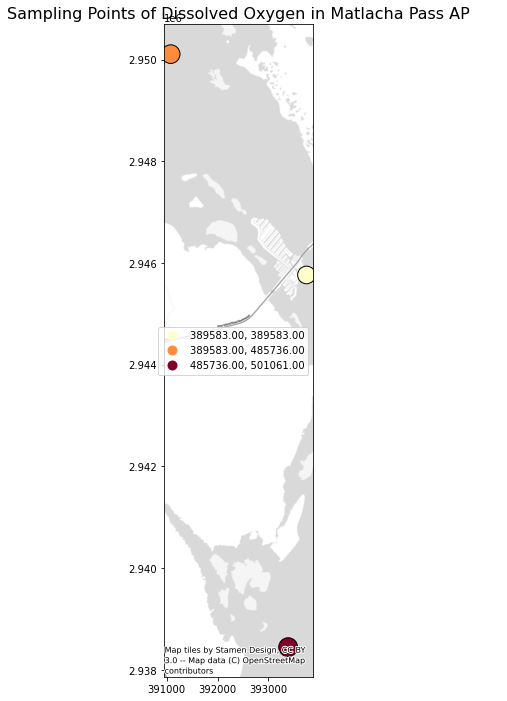

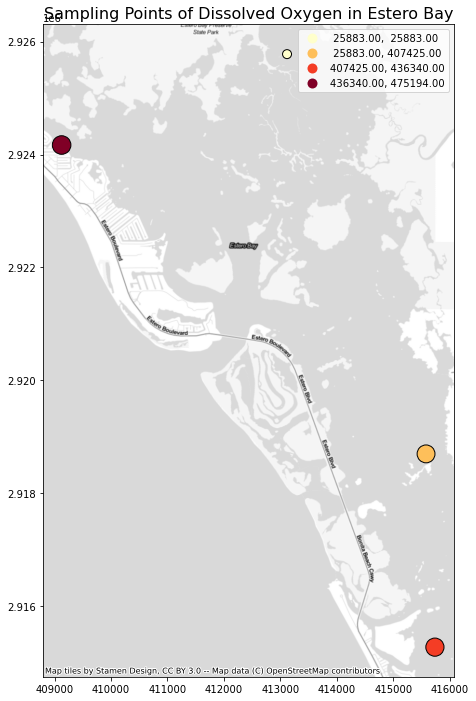

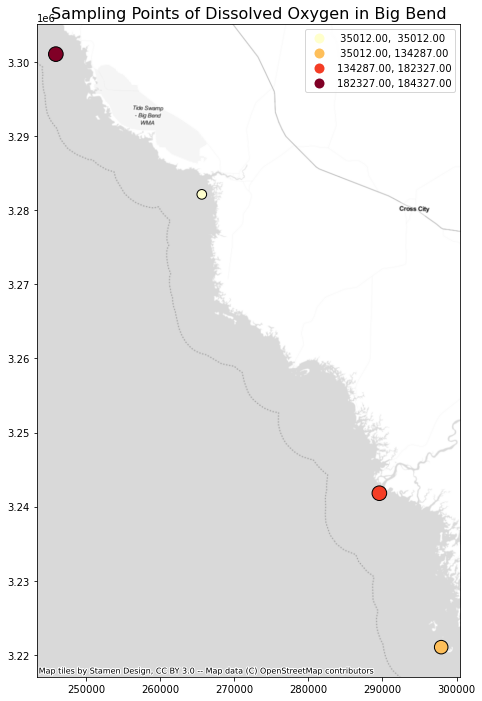

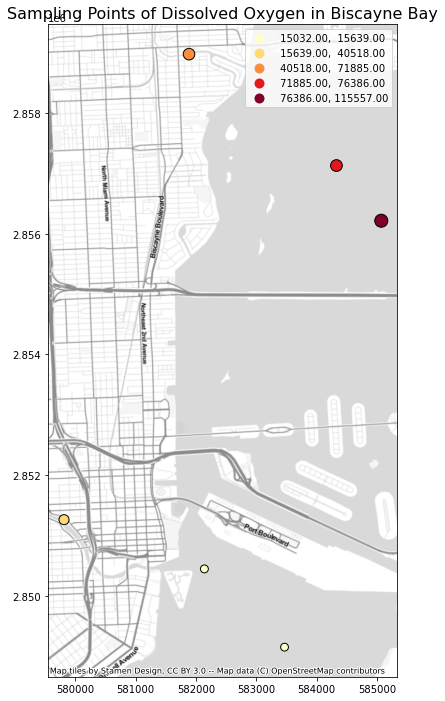

In [25]:
# select parameter and year
para = 'Dissolved Oxygen'

gdfLocPara = gdfLoc[gdfLoc['ParameterName']==para]

fig = plt.figure(figsize = (20, 15))

# This step is to depict the figure about fixed points and random points in each area.
for area in listArea:
    areaPoint = gdfLocPara[gdfLocPara["ManagedAreaName"] == area]
    if areaPoint["ParameterName"].count() != 0:
        #ax = areaPoint.plot(marker="o",facecolors='none', edgecolors='r',markersize=areaPoint['samples'])
        ax = areaPoint.plot(column ='samples',k=5,cmap="YlOrRd", scheme = 'NaturalBreaks',legend=True,
                           marker="o",facecolors='none', edgecolors='black'
                            ,markersize=areaPoint['samples']**(1/2)*0.5
                           )
        ax.set_title("Sampling Points of {} in {}".format(para,str(dictArea[area])),size=16)
        cx.add_basemap(ax,source=cx.providers.Stamen.TonerLite,crs=areaPoint.crs)
        #cx.add_basemap(ax,source=cx.providers.CartoDB.Positron,crs=gdf_Salinity.crs)


### 3.2 Spatial distribution of sampling locations of Dissolved Oxygen in 2019

First, aggregate data by location, parameter name, managed area, year and month.

In [26]:
# Aggregate data
dfLoc_m  = df2.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName","Year","Month"])["ResultValue"].agg("count").reset_index()

dfLoc_m = dfLoc_m.rename(columns={"ResultValue": "samples"})

dfLoc_m.loc[dfLoc_m["samples"] == 1,['sample_type']] ='Random Point'
dfLoc_m.loc[dfLoc_m["samples"] > 1,['sample_type']] ='Fixed Point'

# Convert the data to GeoDataFrame
gdfLoc_m = gpd.GeoDataFrame(dfLoc_m, geometry = gpd.points_from_xy(dfLoc_m.Longitude_DD, dfLoc_m.Latitude_DD),crs="EPSG:4326")

Plot fixed and random sampling location in each managed aera

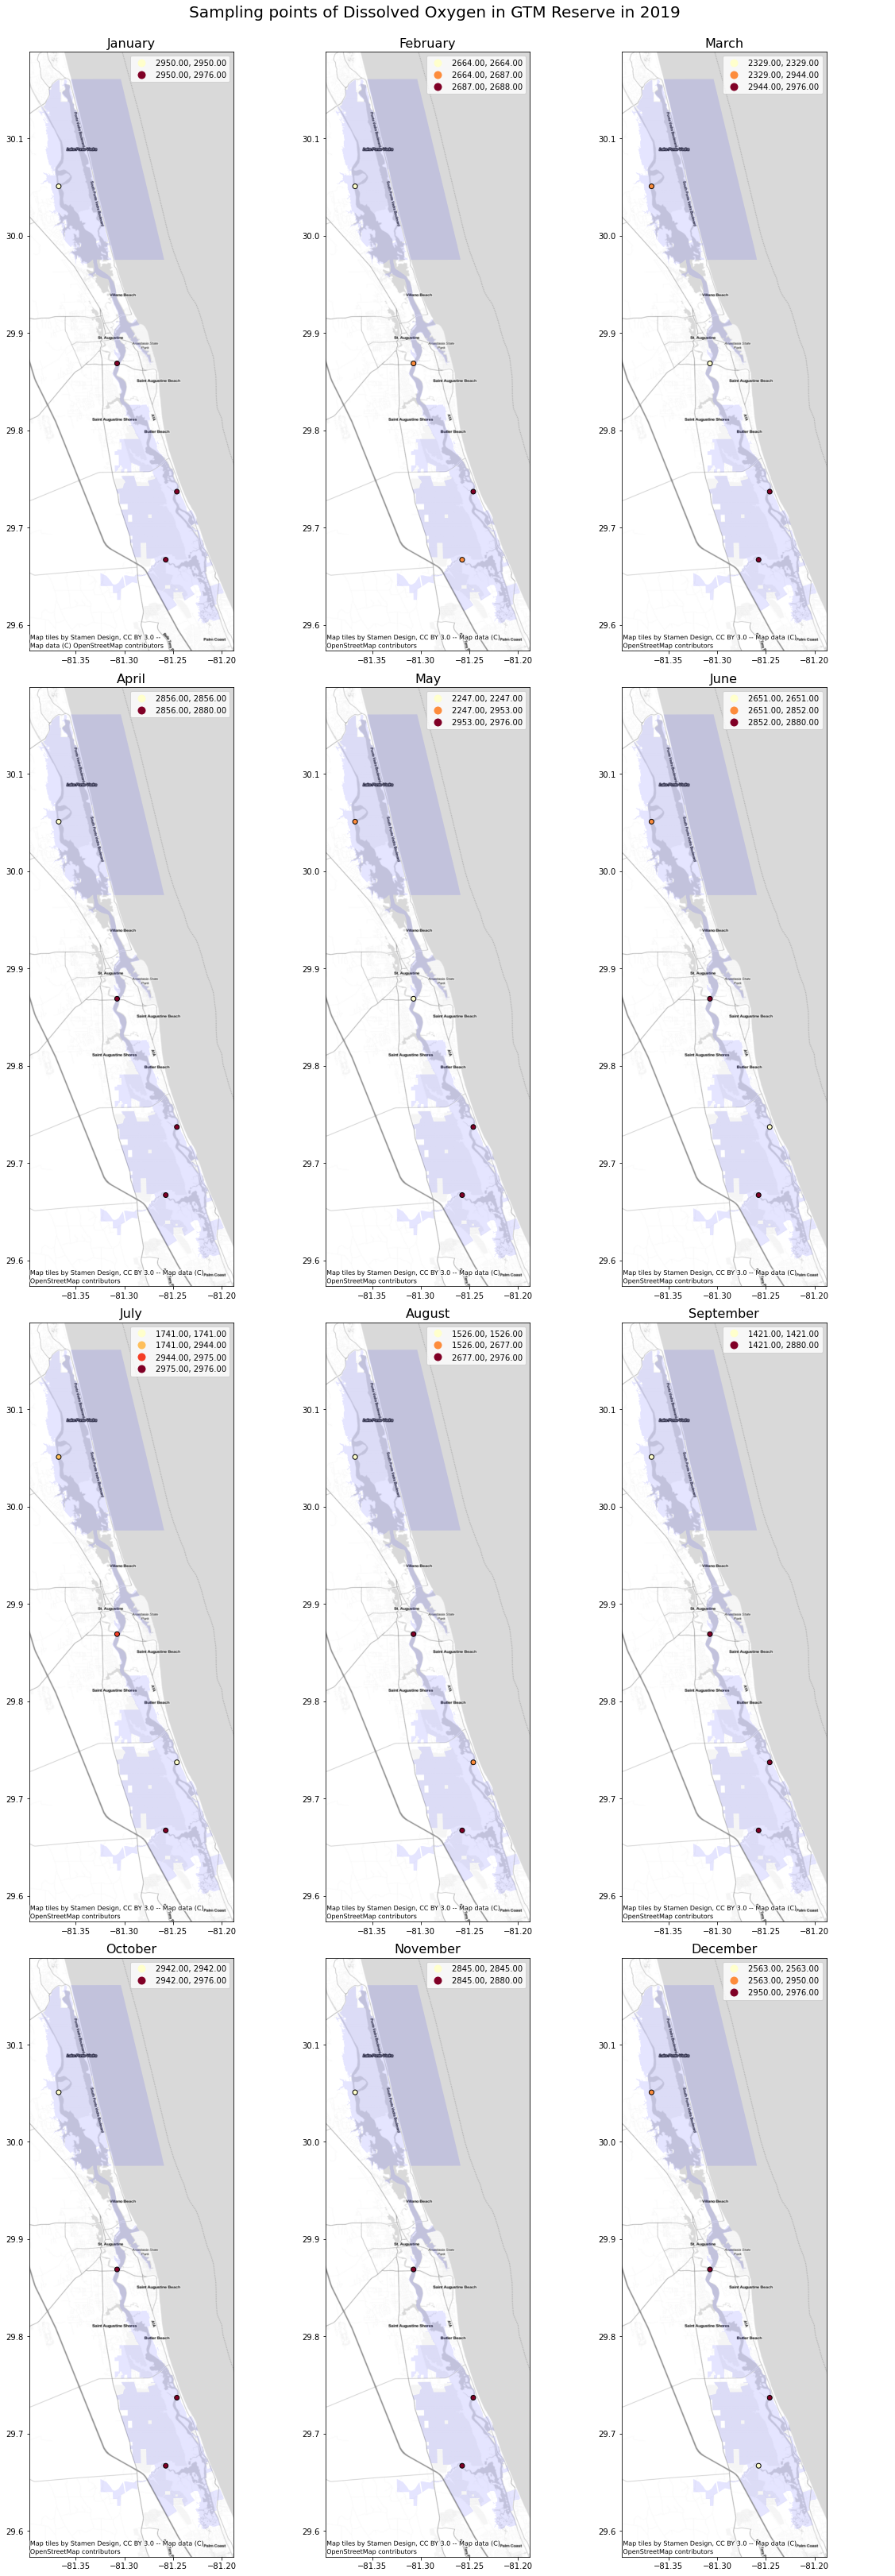

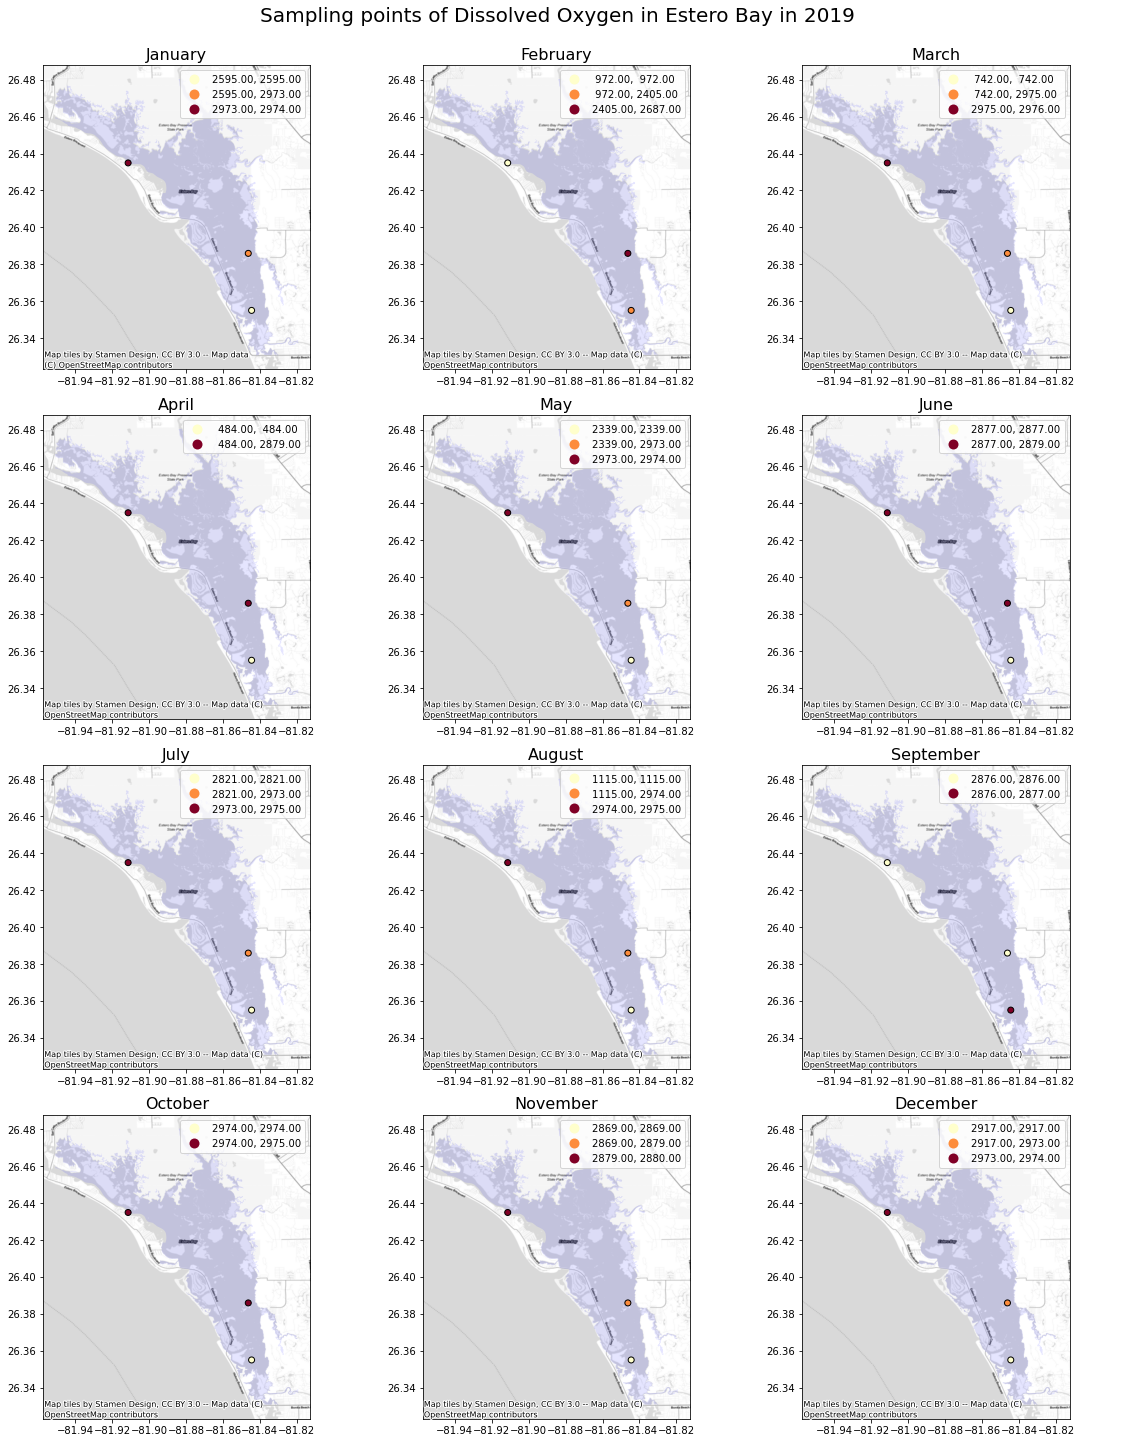

In [29]:
# Select Year and Parameter for the mapping
para, year = 'Dissolved Oxygen', 2019
for area in [listArea[0],listArea[2]]:
#    area = listArea[1]
    
    gdfLocPara = gdfLoc_m[(gdfLoc_m['ParameterName']==para)&(gdfLoc_m["Year"]==year)&(gdfLoc_m["ManagedAreaName"]==area)]
    areaSelect = areaShp[areaShp["LONG_NAME"]==area]

    
    row, col = 4, 3
    fig, axs = plt.subplots(row,col)
    plt.suptitle("Sampling points of {} in {} in {}".format(para, dictArea[area], year), fontsize = 20, y = 1)
    
    # Choose different layout for different managed areas
    if dictArea[area] in ['GTM Reserve', 'Biscayne Bay','Matlacha Pass AP']:
        fig.set_size_inches(16,45)
    else:
        fig.set_size_inches(16,20)
    
    
    i= 1 
    for r in range(0,row):
        for c in range(0,col):
            # Plot polygon of managed area
            areaSelect.plot(facecolor='blue',edgecolor='none',alpha = 0.1,ax=axs[r,c])
            # Select points by month
            areaPoint = gdfLocPara[gdfLocPara["Month"]==i]
#             print(str(areaPoint["ParameterName"].count())+" "+area)
            if areaPoint["ParameterName"].count() != 0:
                areaPoint.plot(column = 'samples' , k = 5, cmap = "YlOrRd", 
                               scheme = 'natural_breaks', marker = "o",
    #                            markersize=areaPoint['samples']**(1)*32,
                               edgecolors='black', legend=True,ax=axs[r,c])
                axs[r,c].set_title(dictMonth[i],size=16)

                cx.add_basemap(axs[r,c],source=cx.providers.Stamen.TonerLite,crs="EPSG:4326")
                plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=0, wspace=0)
                plt.tight_layout()

                plt.show

                if i > 12:
                    break
                else:
                    i = i+1

### 3.3 Sampling locations of Salinity in managed areas in 2019

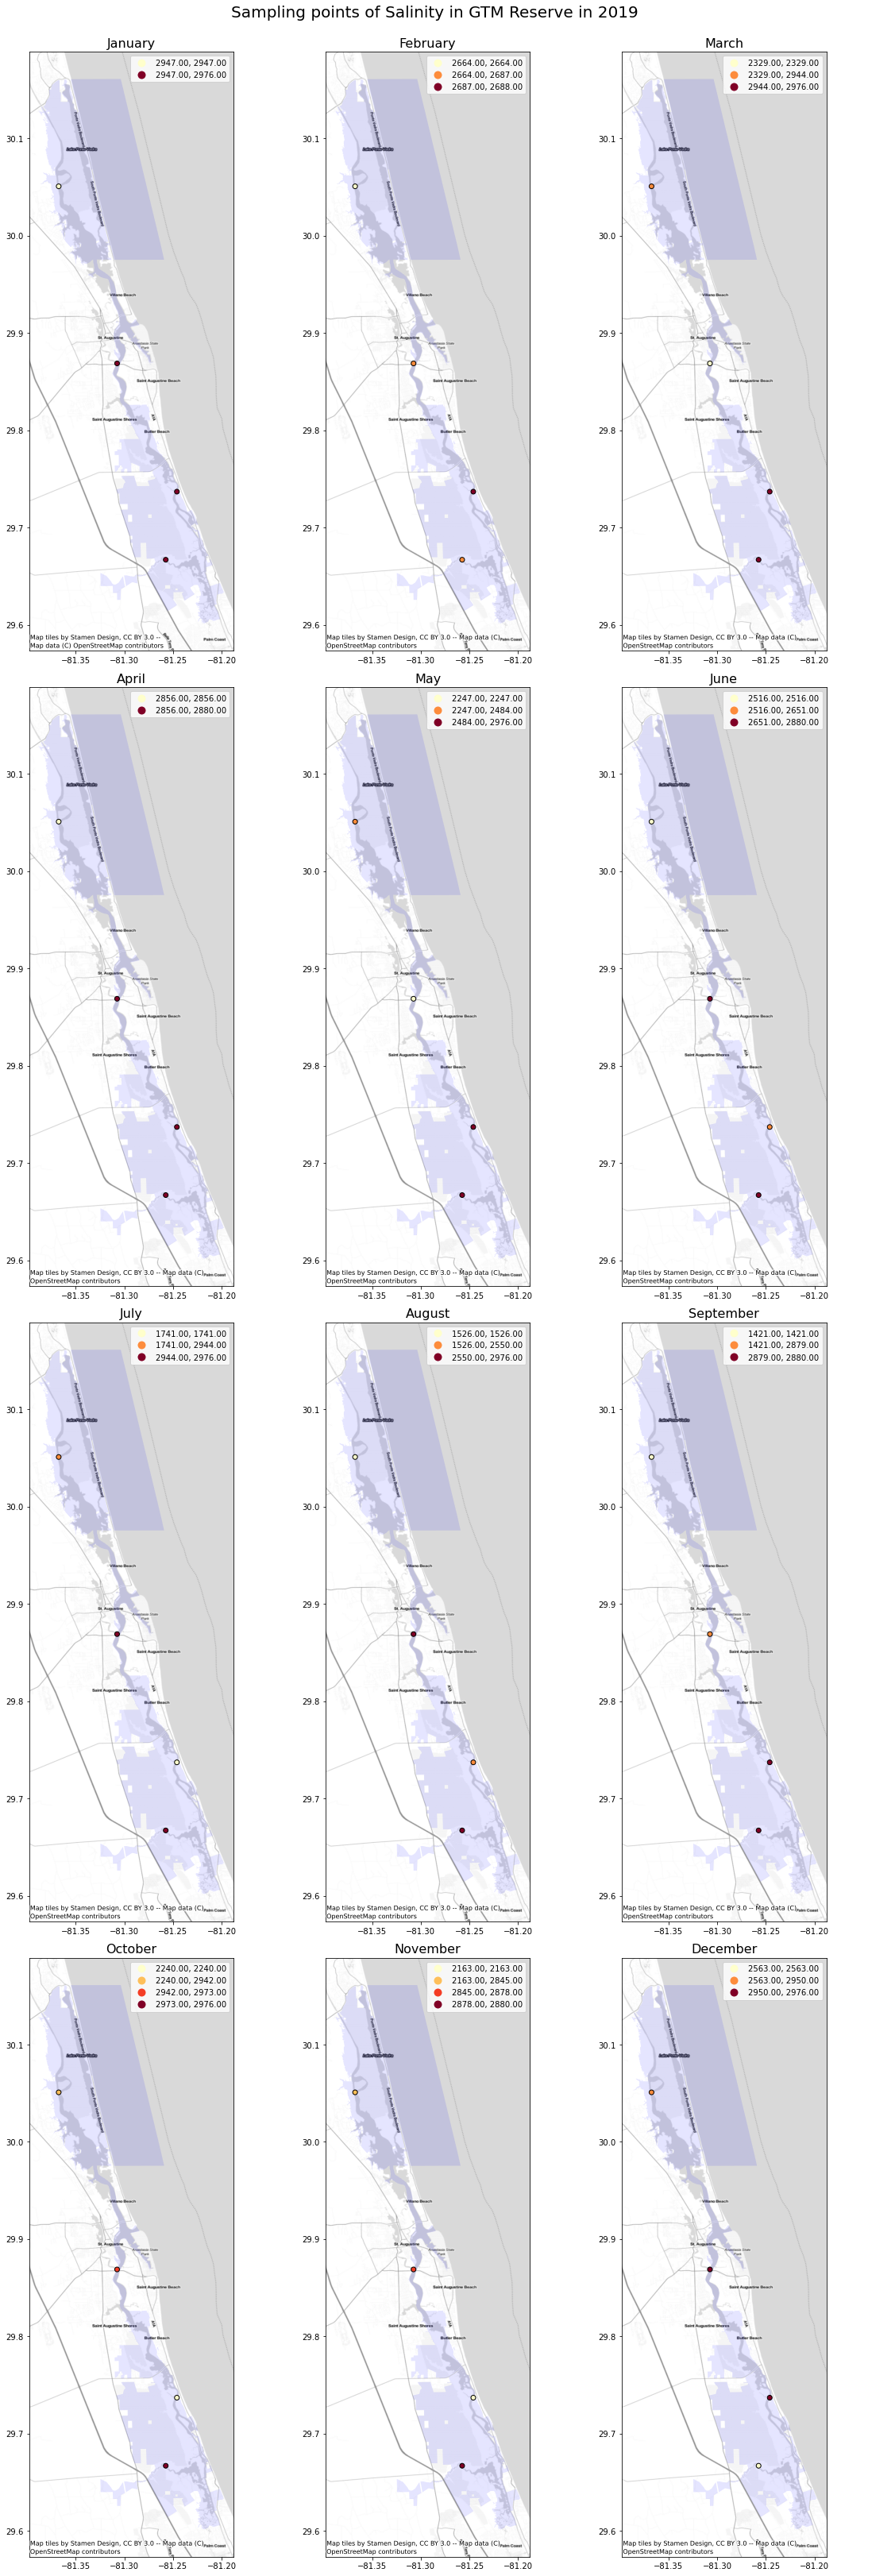

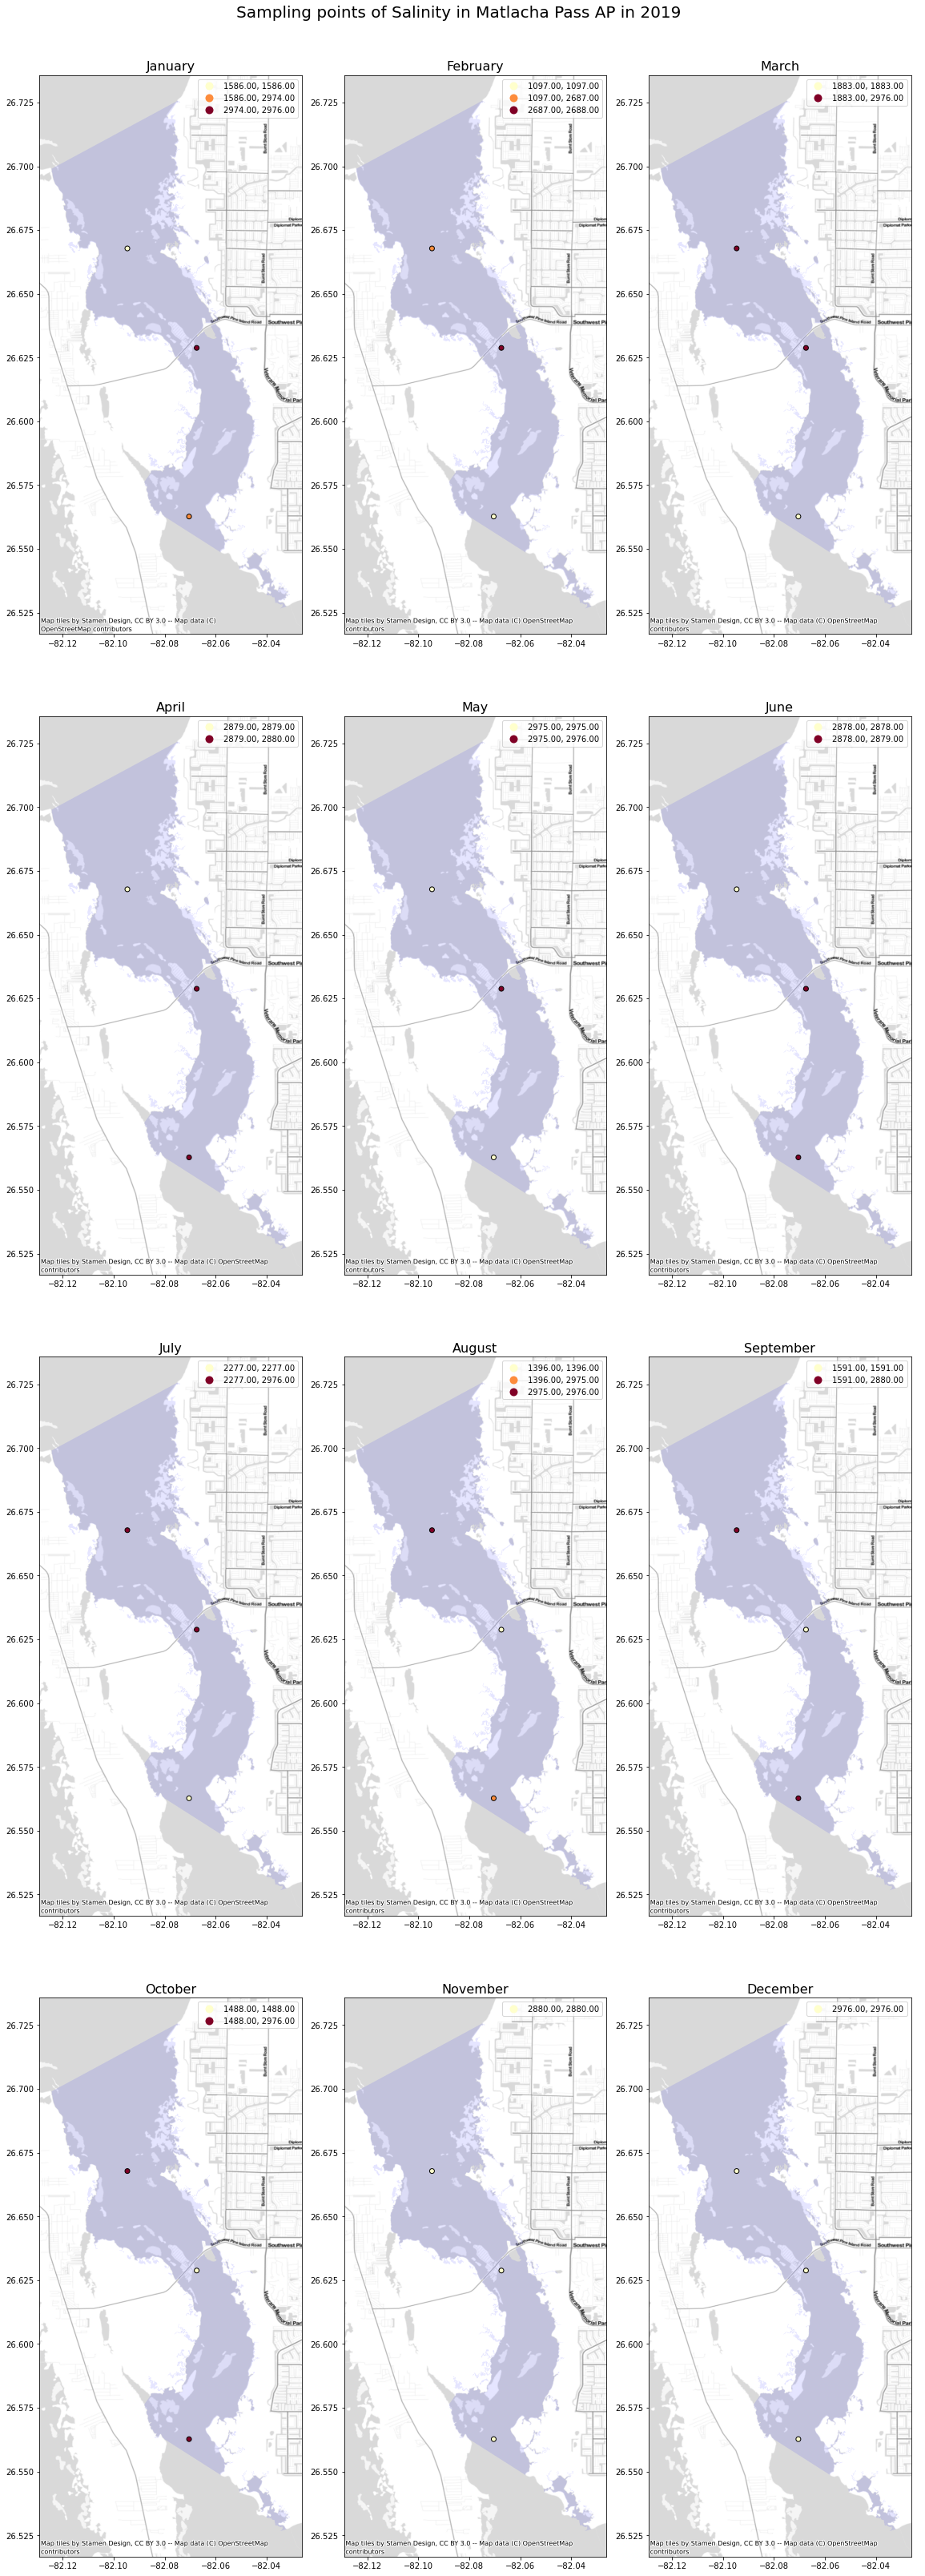

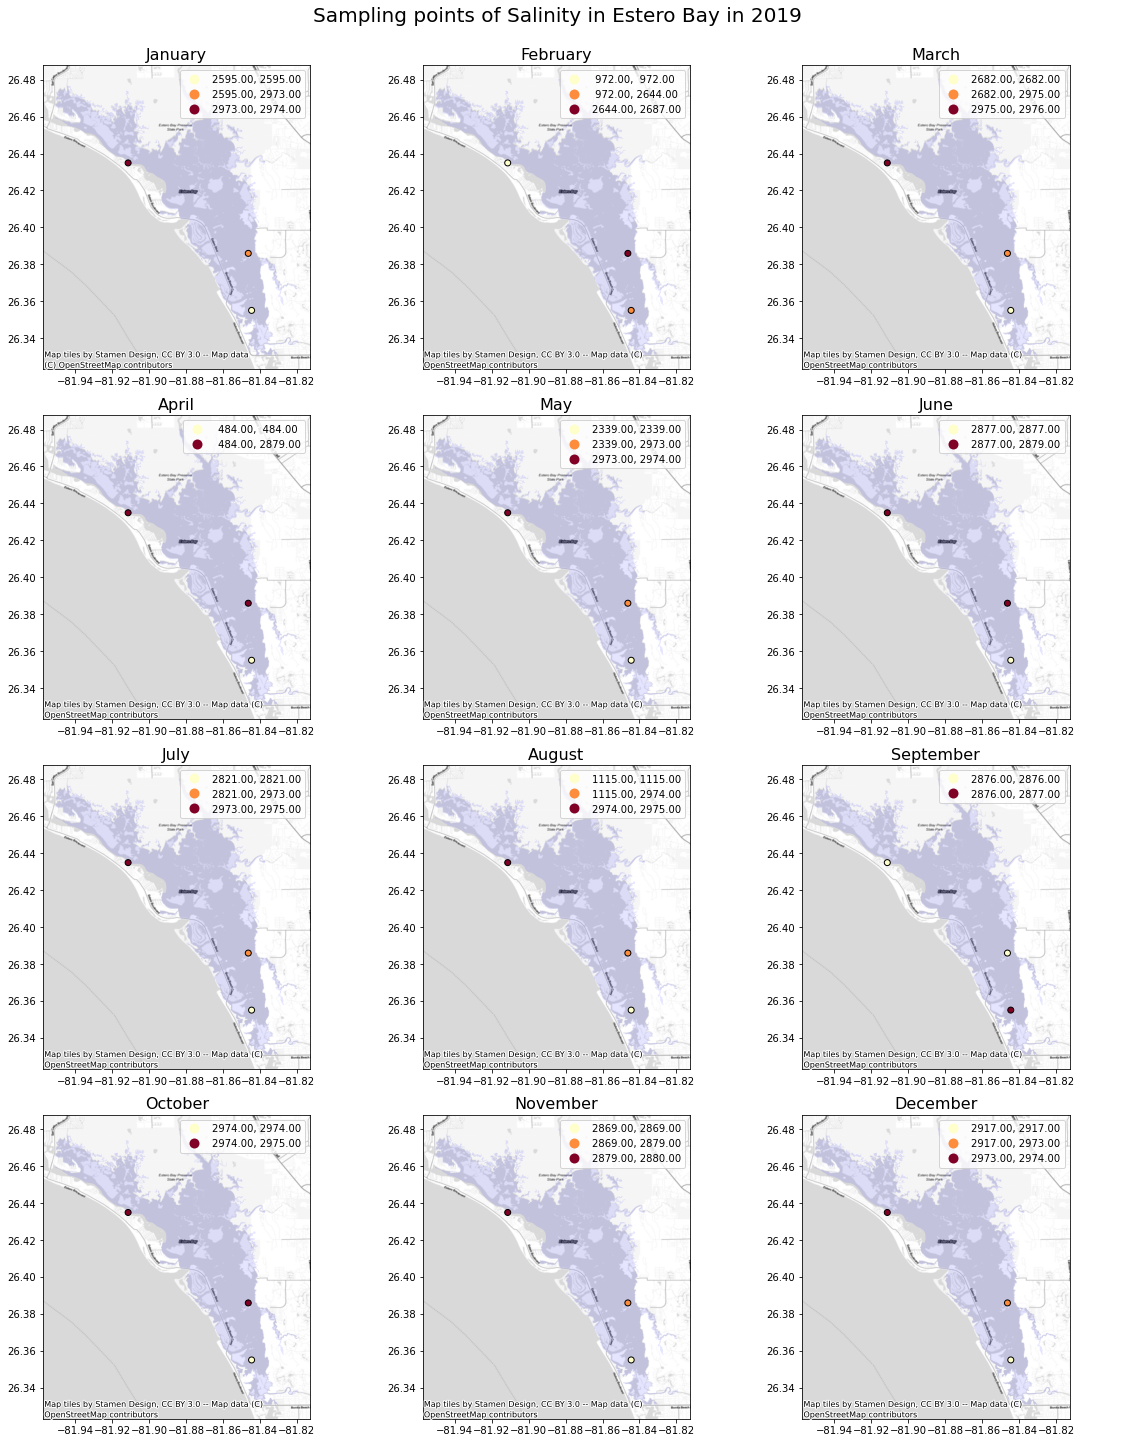

In [30]:
# Select Year and Parameter for the mapping
para, year = 'Salinity', 2019
for area in listArea[0:3]:
#    area = listArea[1]
    
    gdfLocPara = gdfLoc_m[(gdfLoc_m['ParameterName']==para)&(gdfLoc_m["Year"]==year)&(gdfLoc_m["ManagedAreaName"]==area)]
    areaSelect = areaShp[areaShp["LONG_NAME"]==area]

    row, col = 4, 3
    fig, axs = plt.subplots(row,col)
    plt.suptitle("Sampling points of {} in {} in {}".format(para, dictArea[area],year), fontsize = 20, y = 1)
    
    # Choose different layout for different managed areas
    if dictArea[area] in ['GTM Reserve', 'Biscayne Bay','Matlacha Pass AP']:
        fig.set_size_inches(16,45)
    else:
        fig.set_size_inches(16,20)
    
    
    i= 1 
    for r in range(0,row):
        for c in range(0,col):
            # Plot polygon of managed area
            areaSelect.plot(facecolor='blue',edgecolor='none',alpha = 0.1,ax=axs[r,c])
            # Select points by month
            areaPoint = gdfLocPara[gdfLocPara["Month"]==i]
            
            areaPoint.plot(column = 'samples' , k = 5, cmap = "YlOrRd", 
                           scheme = 'natural_breaks', marker = "o",
#                            ,markersize=areaPoint['samples']**(1)*32,
                           edgecolors='black', legend=True,ax=axs[r,c])
            axs[r,c].set_title(dictMonth[i],size=16)

            cx.add_basemap(axs[r,c],source=cx.providers.Stamen.TonerLite,crs="EPSG:4326")
            plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=0, wspace=0)
            plt.tight_layout()
            
            plt.show

            if i > 12:
                break
            else:
                i = i+1